In [47]:
import pandas as pd
#import from pypi
import tqdm
import torch
import warnings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
#local import
from CheXpert2.models.CNN import CNN
from CheXpert2.Metrics import Metrics
from CheXpert2.dataloaders.CXRLoader import CXRLoader
from CheXpert2 import names

In [49]:
def load_model() :
    if torch.cuda.is_available():
        device = "cuda:0"
    else:
        device = "cpu"
        warnings.warn("No gpu is available for the computation")
    models = [
        CNN("convnext_small_384_in22ft1k", img_size=384, channels=3, num_classes=18, pretrained=False,
            pretraining=False),
        #    CNN("convnext_base", img_size=384, channels=1, num_classes=14, pretrained=False, pretraining=False),
        #    CNN("densenet201", img_size=384, channels=1, num_classes=14, pretrained=False, pretraining=False),
        #    CNN("densenet201", img_size=384, channels=1, num_classes=14, pretrained=False, pretraining=False),
    ]
    # model =  torch.nn.parallel.DistributedDataParallel(model)

    # api = wandb.Api()
    # run = api.run(f"ccsmtl2/Chestxray/{args.run_id}")
    # run.file("models_weights/convnext_base/DistributedDataParallel.pt").download(replace=True)
    weights = [
        "/mnt/c/Users/joeda/PycharmProjects/IA-MED_IMG/data/model_weights/flowing_wind.pt",
        #    "/data/home/jonathan/IA-MED_IMG/models_weights/convnext_base_2.pt",
        #    "/data/home/jonathan/IA-MED_IMG/models_weights/densenet201.pt",
        #    "/data/home/jonathan/IA-MED_IMG/models_weights/densenet201_2.pt",
    ]

    for model, weight in zip(models, weights):
        state_dict = torch.load(weight, map_location=torch.device(device))

        # from collections import OrderedDict
        # new_state_dict = OrderedDict()
        # for k, v in state_dict.items():
        #     name = k[7:]  # remove 'module.' of DataParallel/DistributedDataParallel
        #     new_state_dict[name] = v

        # model.load_state_dict(new_state_dict)
        model.load_state_dict(state_dict)
        # model = model.to(device)
        model.eval()
        model = model.to(device)
        return model

In [50]:
@torch.no_grad()
def infer_loop(model, loader, criterion, device):
    """

    :param model: model to evaluate
    :param loader: dataset loader
    :param criterion: criterion to evaluate the loss
    :param device: device to do the computation on
    :return: val_loss for the N epoch, tensor of concatenated labels and predictions
    """
    running_loss = 0
    results = [torch.tensor([]), torch.tensor([])]

    for inputs, labels,idx in tqdm.tqdm(loader):
        # get the inputs; data is a list of [inputs, labels]

        inputs, labels = (
            inputs.to(device, non_blocking=True),
            labels.to(device, non_blocking=True),
        )
        #inputs,labels = loader.dataset.advanced_transform((inputs, labels))
        # forward + backward + optimize

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        outputs = torch.sigmoid(outputs)
        running_loss += loss.detach()

        if inputs.shape != labels.shape:  # prevent storing images if training unets
            results[1] = torch.cat(
                (results[1], outputs.detach().cpu()), dim=0
            )
            results[0] = torch.cat((results[0], labels.cpu()), dim=0)

        del (
            inputs,
            labels,
            outputs,
            loss,
        )  # garbage management sometimes fails with cuda


    return running_loss, results


In [51]:
criterion = torch.nn.BCEWithLogitsLoss()
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
    warnings.warn("No gpu is available for the computation")

# ----- parsing arguments --------------------------------------


#start = torch.cuda.Event(enable_timing=True)
#end = torch.cuda.Event(enable_timing=True)
# ------loading test set --------------------------------------
#img_dir = os.environ["img_dir"]
img_dir = "/mnt/c/Users/joeda/PycharmProjects/IA-MED_IMG"
os.environ["DEBUG"]="True"
test_dataset = CXRLoader("Valid",img_dir, img_size=384,channels=3,datasets=["ChexPert"])

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)
# ----------------loading model -------------------------------

model=load_model()
i=0

/mnt/c/Users/joeda/PycharmProjects/IA-MED_IMG/CheXpert2/dataloaders/CXRLoader.py:177: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=data.groupby("Exam ID").mean().round(0)


In [52]:

#start.record()
import time
start = time.time()
running_loss, results = infer_loop(model=model, loader=test_loader, criterion=criterion, device=device)
#end.record()
end=time.time()
#torch.cuda.synchronize()
#print("time : ", start.elapsed_time(end))
print(end-start)
#plt.imshow(np.sum(heatmaps[0][0].detach().cpu().numpy(), axis=0))
#plt.savefig("heatmaps.png")

metric = Metrics(num_classes=18, names=names, threshold=np.zeros((18)) + 0.5)
metrics = metric.metrics()
metrics_results = {}
for key in metrics:
    pred = results[1].numpy()
    true = results[0].numpy().round(0)
    metric_result = metrics[key](true, pred)
    metrics_results[key] = metric_result

print(metrics_results)
i=0

100%|██████████| 200/200 [00:06<00:00, 29.13it/s]

6.870706796646118
{'auc': {'Opacity': 0.6564996368917937, 'Air': 0.9170984455958548, 'Liquid': 0.8712571831837888, 'Cardiomegaly': 0.7051108095884215, 'Lung Lesion': 0.9949748743718593, 'Emphysema': 0, 'Edema': 0.872664255575648, 'Consolidation': 0.7686011904761905, 'Atelectasis': 0.6701866666666667, 'Pneumothorax': 0.9132302405498282, 'Pleural Effusion': 0.8933823529411764, 'Fracture': 0, 'Hernia': 0, 'Infiltration': 0, 'Mass': 0, 'Nodule': 0, 'Pleural Other': 0.9899497487437185, 'No Finding': 0.8216180371352785, 'mean': 0.5596985245400126}, 'f1': 0.28263975394704194, 'recall': {'Opacity': 1.0, 'Air': 1.0, 'Liquid': 1.0, 'Cardiomegaly': 0.7878787878787878, 'Lung Lesion': 1.0, 'Emphysema': 0.0, 'Edema': 1.0, 'Consolidation': 1.0, 'Atelectasis': 1.0, 'Pneumothorax': 1.0, 'Pleural Effusion': 1.0, 'Fracture': 0.0, 'Hernia': 0.0, 'Infiltration': 0.0, 'Mass': 0.0, 'Nodule': 0.0, 'Pleural Other': 0.0, 'No Finding': 1.0}, 'precision': {'Opacity': 0.43783783783783786, 'Air': 0.1014492753623188

In [53]:
"""
FOR A SPECIFIC IMAGE
"""
#inputs,labels=test_dataset[i]
#Manually loading images
import cv2 as cv
from pytorch_grad_cam import FullGrad
from PIL import Image
cam=FullGrad(model,target_layers=[])
img_size=384
img_dir=""
path0="c:/Users/joeda/PycharmProjects/IA-MED_IMG/data/1808916906062113_view0001.jpg"
path1="c:/Users/joeda/PycharmProjects/IA-MED_IMG/data/1808916906062113_view0002.jpg"
assert os.path.exists(path0)
image0 = np.array(cv.resize(cv.imread(f"{img_dir}{path0}", cv.IMREAD_GRAYSCALE),(img_size,img_size)))
image1 = np.array(cv.resize(cv.imread(f"{img_dir}{path1}", cv.IMREAD_GRAYSCALE),(img_size,img_size)))
inputs = np.concatenate([image0[None,:,:],image1[None,:,:]],axis=0)
inputs=inputs[None,:,:,:]
# inputs, labels = (
#             inputs.to(device, non_blocking=True),
#             labels.to(device, non_blocking=True),
#         )


inputs = torch.from_numpy(inputs).to(device,non_blocking=True)
# forward + backward + optimize
outputs = model(inputs)
img0=inputs[:,0:1,:,:]
heatmap0 = cam(img0.float()).squeeze() * -255+255


img1=inputs[:,1:2,:,:]
heatmap1 = cam(img1.float()).squeeze() * -255+255


heatmap0 = np.array(cv.applyColorMap(cv.cvtColor(heatmap0[:, :, None].astype(np.uint8), cv.COLOR_RGB2BGR),
                                          cv.COLORMAP_JET))

heatmap1 = np.array(cv.applyColorMap(cv.cvtColor(heatmap1[:, :, None].astype(np.uint8), cv.COLOR_RGB2BGR),
                                          cv.COLORMAP_JET))

Image.fromarray(heatmap0).save("c:/Users/joeda/PycharmProjects/IA-MED_IMG/dataheatmap_frontal.jpg")
Image.fromarray(heatmap1).save("c:/Users/joeda/PycharmProjects/IA-MED_IMG/dataheatmap_lateral.jpg")
img0=img0.cpu().numpy().astype(np.uint8).squeeze()
img1=img1.cpu().numpy().astype(np.uint8).squeeze()
img0 = cv.cvtColor(img0,cv.COLOR_GRAY2RGB)
img1=cv.cvtColor(img1,cv.COLOR_GRAY2RGB)
heatmap0 = cv.addWeighted(heatmap0, 0.5, img0, 0.5, 0)
heatmap1 = cv.addWeighted(heatmap1, 0.5, img1, 0.5, 0)
plt.imshow(heatmap0.squeeze())
plt.show()
plt.imshow(heatmap1.squeeze())
plt.show()
labels=torch.zeros_like(outputs).to(device)
#loss = criterion(outputs.squeeze(), labels)
outputs = torch.sigmoid(outputs)

i+=1
plt.imshow(inputs.squeeze().numpy())
data=pd.DataFrame([outputs.detach().numpy().squeeze(),labels.numpy().squeeze()],columns=names,index=["preds","ground-truth"])

print(data.T)


AssertionError: 

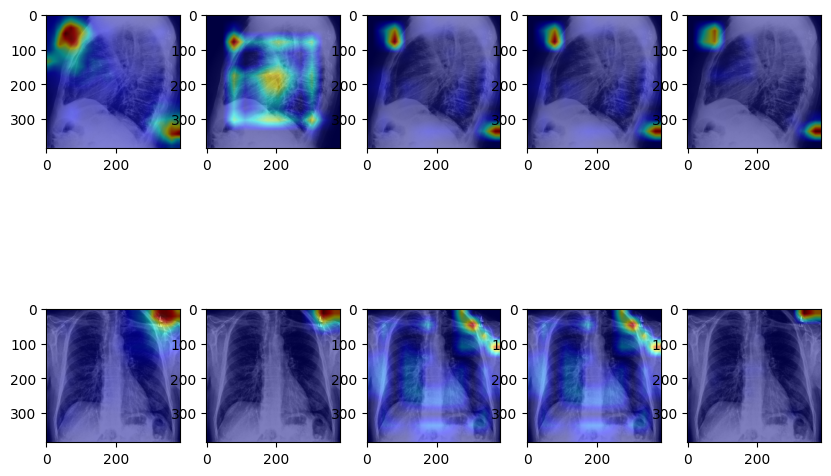

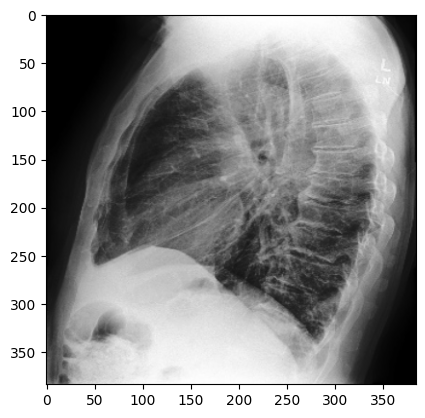

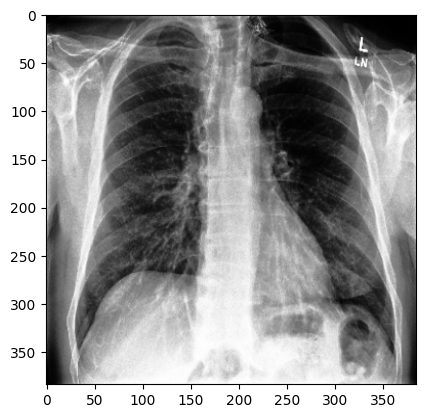

                     preds  ground-truth
Opacity           0.406800           0.0
Air               0.933800           0.0
Liquid            0.473506           0.0
Cardiomegaly      0.752405           0.0
Lung Lesion       0.563990           0.0
Emphysema         0.010992           0.0
Edema             0.209039           0.0
Consolidation     0.398821           0.0
Atelectasis       0.462349           0.0
Pneumothorax      0.975465           0.0
Pleural Effusion  0.594443           0.0
Fracture          0.663119           0.0
Hernia            0.001033           0.0
Infiltration      0.004549           0.0
Mass              0.008385           0.0
Nodule            0.000951           0.0
Pleural Other     0.001151           0.0
No Finding        0.974440           0.0


In [60]:
"""
FOR A SPECIFIC IMAGE
"""
#inputs,labels=test_dataset[i]
#Manually loading images
import cv2 as cv
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import FullGrad,EigenCAM,GradCAM,HiResCAM,GradCAMPlusPlus
from PIL import Image

cams=[
    FullGrad(model,target_layers=[]),
    EigenCAM(model,target_layers=[model.backbone.stages[-1]]),
    GradCAM(model,target_layers=[model.backbone.stages[-1]]),
    HiResCAM(model,target_layers=[model.backbone.stages[-1]]),
    GradCAMPlusPlus(model,target_layers=[model.backbone.stages[-1]]),
]
img_size=512

inputs,labels,idx = test_dataset[i]
inputs = inputs[None,:,:,:]
inputs = inputs.to(device,non_blocking=True)
# forward + backward + optimize
outputs = model(inputs)
img0=inputs[:,0:1,:,:]
img1=inputs[:,1:2,:,:]
# create figure
fig = plt.figure(figsize=(10, 7))

img0_display=img0.cpu().numpy().astype(np.uint8).squeeze()
img1_display=img1.cpu().numpy().astype(np.uint8).squeeze()
img0_display = cv.cvtColor(img0_display,cv.COLOR_GRAY2RGB)
img1_display=cv.cvtColor(img1_display,cv.COLOR_GRAY2RGB)

rows=2
columns=len(cams)

targets = [ClassifierOutputTarget(i) for i,output in enumerate(outputs.squeeze().cpu().tolist()) if output>0.5]

for ex,cam in enumerate(cams,start=1) :
    heatmap0 = cam(img0.float(),targets=targets).squeeze() * -255+255
    heatmap1 = cam(img1.float(),targets=targets).squeeze() * -255+255

    fig.add_subplot(rows, columns, ex)
    heatmap0 = np.array(cv.applyColorMap(cv.cvtColor(heatmap0[:, :, None].astype(np.uint8), cv.COLOR_RGB2BGR),cv.COLORMAP_JET))
    heatmap0 = cv.addWeighted(heatmap0, 0.5, img0_display, 0.5, 0)
    plt.imshow(heatmap0.squeeze())

    fig.add_subplot(rows, columns, len(cams)+ex)
    heatmap1 = np.array(cv.applyColorMap(cv.cvtColor(heatmap1[:, :, None].astype(np.uint8), cv.COLOR_RGB2BGR),cv.COLORMAP_JET))
    heatmap1 = cv.addWeighted(heatmap1, 0.5, img1_display, 0.5, 0)
    plt.imshow(heatmap1.squeeze())

i+=1
plt.show()
plt.imshow(img0_display)
plt.show()
plt.imshow(img1_display)
plt.show()
#Image.fromarray(heatmap0).save("c:/Users/joeda/PycharmProjects/IA-MED_IMG/dataheatmap_frontal.jpg")
#Image.fromarray(heatmap1).save("c:/Users/joeda/PycharmProjects/IA-MED_IMG/dataheatmap_lateral.jpg")

labels=torch.zeros_like(outputs).to(device)
#loss = criterion(outputs.squeeze(), labels)
outputs = torch.sigmoid(outputs)

data=pd.DataFrame([outputs.cpu().detach().numpy().squeeze(),labels.cpu().numpy().squeeze()],columns=names,index=["preds","ground-truth"])

print(data.T)